<b><font color="black" size="+4">Portrait Enchancer</font></b>

<b><font color="black" size="+2">Based on:</font></b>

**GitHub repository**: [DFDNet](https://github.com/csxmli2016/DFDNet)

Article: [Blind Face Restoration via Deep Multi-scale Component Dictionaries](https://arxiv.org/pdf/2008.00418.pdf)

Creator: **[csxmli2016](https://github.com/csxmli2016).**

<b><font color="black" size="+2">Colab created by:</font></b>

GitHub: [@tg-bomze](https://github.com/tg-bomze),
Telegram: [@bomze](https://t.me/bomze),
Twitter: [@tg_bomze](https://twitter.com/tg_bomze).


---


```
(ENG) To get started, click on the button (where the red arrow indicates). After clicking, wait until the execution is complete.
```
```
(RUS) Чтобы начать, нажмите на кнопку (куда указывает красная стрелка), после чего дождитесь завершения выполнения блока.
```



In [3]:
!pip uninstall moviepy
!pip install moviepy==1.0.3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 388 kB 7.2 MB/s 
     |████████████████████████████████| 26.9 MB 1.6 MB/s 
  Created wheel for moviepy: filename=moviepy-1.0.3-py3-none-any.whl size=110743 sha256=4bd325612ae3d08f55734b6a721c2122887406612c6b7895883e56ee2a672e9c
  Stored in directory: /root/.cache/pip/wheels/56/dc/2b/9cd600d483c04af3353d66623056fc03faed76b7518faae4df
Successfully built moviepy


In [1]:
#@title <b><font color="red" size="+3">←</font><font color="black" size="+3"> Clone Git repository and install all requirements</font></b>
#@markdown <b><font color="black" size="+1"> (RUS) Клонируем репозиторий и устанавливаем всё необходимое</font></b>

!pip install dominate
!pip install ffmpeg

from google.colab import drive
from IPython.display import clear_output
from IPython import display as ipythondisplay
import moviepy.editor as mpy
from moviepy.video.io.ffmpeg_writer import FFMPEG_VideoWriter
from google.colab import files
from PIL import Image
import matplotlib.pyplot as plt
import warnings
import ffmpeg
import cv2
import os
import io
import base64

warnings.filterwarnings("ignore")
%matplotlib inline

!rm -rf /content/sample_data
!git clone https://github.com/tg-bomze/DFDNet.git

!mkdir /content/DFDNet/checkpoints/
!mkdir /content/DFDNet/checkpoints/facefh_dictionary
!mkdir /content/DFDNet/weights/
!mkdir /content/DFDNet/DictionaryCenter512/

os.chdir('/content/DFDNet/FaceLandmarkDetection/')
!python setup.py install
os.chdir('/content/')
clear_output()
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-319142b6-dc77-607c-34df-2db0d9d908de)


In [2]:
#@title <b><font color="red" size="+3">←</font><font color="black" size="+3"> Save the weights of the pretrained model and mount Google Drive</font></b>
#@markdown <b><font color="black" size="+1"> (RUS) Сохраняем веса предобученной модели на Гугл Диск</font></b>


#@markdown **Follow this link: https://drive.google.com/drive/folders/1bayYIUMCSGmoFPyd4Uu2Uwn347RW-vl5**

#@markdown <font color="red">**1**</font>) right click on '**DFDNet**' (top center)

#@markdown <font color="red">**2**</font>) select '**Add shortcut to Drive**'

#@markdown ![](https://raw.githubusercontent.com/tg-bomze/DFDNet/whole/shortcut.JPG)

#@markdown <font color="red">**3**</font>) **run this block and follow the further instructions**

#@markdown *(ENG) Attention! If the weights have already been saved, then run this block and just mount Google Drive.*

#@markdown *(RUS) Внимание! Если веса уже сохранены, то только запустите этот блок и смонтируйте Гугл Драйв.*

print("(ENG) Follow the link below, select the account where you saved the pretrained model,")
print("click the 'Allow' button, copy authorization code in the field below and press Enter.\n")

print("(RUS) Перейдите по ссылке ниже, выберите аккаунт, куда сохранили предобученную модель,")
print("нажмите на кнопку 'Разрешить', скопируйте авторизационный код в нижнее поле и нажмите Enter.\n")
drive.mount('/content/drive')
clear_output()
print("0%/100%   Copying has started and will take about 4 minutes.")
!cp '/content/drive/My Drive/DFDNet/checkpoints/facefh_dictionary/latest_net_G.pth' '/content/DFDNet/checkpoints/facefh_dictionary'
print("33%/100%  Checkpoints copied")
!cp '/content/drive/My Drive/DFDNet/weights/vgg19.pth' '/content/DFDNet/weights/'
print("66%/100%  Weights copied")
!cp -r '/content/drive/My Drive/DFDNet/DictionaryCenter512/' '/content/DFDNet/'
print("100%/100% Dictionary copied")
clear_output()
print("Done!")

Done!


Video uploaded. Number of frames: 150. First frame:



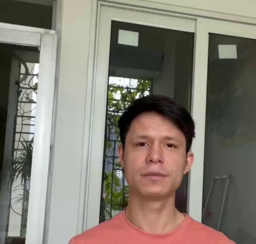

In [13]:
#@title <b><font color="red" size="+3">←</font><font color="black" size="+3"> Uploading a single face photo or video</font></b>
#@markdown <b><font color="black" size="+1"> (RUS) Загружаем фото или видео с одним лицом</font></b>

os.chdir('/content/')
!rm -rf /content/DFDNet/Results
!rm -rf /content/DFDNet/TestData/TestWhole/*

file_type = 'Video' #@param ["Photo", "Video"]
#@markdown ---
if file_type == 'Photo':
  uploaded = list(files.upload().keys())
  if len(uploaded) > 1:
    raise ValueError('You cannot upload more than one audio at a time!')
  cont = uploaded[0]
  CONTENT_FILENAME = "content." + cont.split(".")[-1]
  os.rename(cont, CONTENT_FILENAME)
  content_path = "/content/DFDNet/TestData/TestWhole/" + CONTENT_FILENAME
  !mv -f $CONTENT_FILENAME $content_path
  clear_output()
  try:
    pil_content = Image.open(content_path)
    (cont_width, cont_height) = pil_content.size
    resize_cont = max(cont_width, cont_height)/256
    display(pil_content.resize((int(cont_width/resize_cont), int(cont_height/resize_cont))))
  except: print("Photo uploaded!")
else:
  #@markdown **You can paste the YouTube link here:**
  source_url = '' #@param {type:"string"}
  if source_url == '':
    uploaded = files.upload()
    for fn in uploaded.keys():
      print('User uploaded file "{name}" with length {length} bytes'.format(
          name=fn, length=len(uploaded[fn])))
    file_name = "/content/downloaded_video." + fn.split(".")[-1]
    !mv -f $fn $file_name
  else:
    !pip install youtube_dl
    import youtube_dl
    try:
      ydl_opts = {
          'format': 'bestvideo[ext=mp4]+bestaudio[ext=m4a]/mp4',
          'outtmpl': 'downloaded_video.mp4',
          }
      with youtube_dl.YoutubeDL(ydl_opts) as ydl:
        ydl.download([source_url])
      file_name = '/content/downloaded_video.mp4'
    except BaseException:
      !wget $source_url
      fn = source_url.split('/')[-1]
      file_name = "/content/downloaded_video." + fn.split(".")[-1]
      !mv -f $fn $file_name

  #@markdown **Crop video (h:m:s)**
  target_start = '00:00:00' #@param {type:"string"}
  target_end = '00:00:05' #@param {type:"string"}
  if target_end != '00:00:00':
    new_file_name = 'new_target.' + file_name.split('.')[-1]
    !ffmpeg -i $file_name -ss $target_start -to $target_end $new_file_name
    !mv -f $new_file_name $file_name

  !ffmpeg -y -i $file_name -vn -ar 44100 -ac 2 -ab 192K -f mp3 /content/sound.mp3

  vidcap = cv2.VideoCapture(file_name)
  success,image = vidcap.read()
  count = 0
  success = True
  while success:
    cv2.imwrite("/content/DFDNet/TestData/TestWhole/frame%09d.jpg" % count, image)
    success,image = vidcap.read()
    count += 1

  clear_output()
  try:
    fps_of_video = int(cv2.VideoCapture(file_name).get(cv2.CAP_PROP_FPS))
    frames_of_video = int(cv2.VideoCapture(file_name).get(cv2.CAP_PROP_FRAME_COUNT))
    print("Video uploaded. Number of frames: {}. First frame:\n".format(str(frames_of_video)))
  except: print("Video uploaded! First frame:\n")

  pil_content = Image.open('/content/DFDNet/TestData/TestWhole/frame000000000.jpg')
  (cont_width, cont_height) = pil_content.size
  resize_cont = max(cont_width, cont_height)/256
  display(pil_content.resize((int(cont_width/resize_cont), int(cont_height/resize_cont))))

In [19]:
#@title <b><font color="red" size="+3">←</font><font color="black" size="+3"> Start enchance</font></b>
#@markdown <b><font color="black" size="+1"> (RUS) Начать улучшение</font></b>

%%time
#@markdown **How many times to upscale the image?**
upscale_factor = 4 #@param {type:"slider", min:1, max:4, step:1}
os.chdir('/content/DFDNet/')
!python test_FaceDict.py --test_path ./TestData/TestWhole --results_dir ./Results/TestWholeResults --upscale_factor $upscale_factor --gpu_ids 0
clear_output()
try: 
  enchance_face_path = '/content/DFDNet/Results/TestWholeResults/Step3_RestoreCropFace/' + CONTENT_FILENAME
  pil_result = Image.open(enchance_face_path)
  (res_width, res_height) = pil_result.size
  resize_res = max(res_width, res_height)/256
  display(pil_result.resize((int(res_width/resize_res), int(res_height/resize_res))))
except: 
  print('Images enchanced')
  enchance_face_path = '/content/DFDNet/Results/TestWholeResults/Step3_RestoreCropFace/'

Images enchanced
CPU times: user 746 ms, sys: 117 ms, total: 864 ms
Wall time: 48.5 s


In [15]:
#@title <b><font color="red" size="+3">←</font><font color="black" size="+3"> Upscaled and combine with the original image</font></b>
#@markdown <b><font color="black" size="+1"> (RUS) Объединяем с оригинальным изображением</font></b>

%%time
!rm -rf /content/DFDNet/Results/TestWholeResults/Step4_FinalResults
print('\n###############################################################################')
print('############### Step 4: Paste the Restored Face to the Input Image ############')
print('###############################################################################\n')
from data.image_folder import make_dataset
from skimage import io
import numpy as np
import cv2
import dlib

def reverse_align(input_path, face_path, param_path, save_path, upsample_scale=2):
    out_size = (512, 512) 
    input_img = dlib.load_rgb_image(input_path)
    h,w,_ = input_img.shape
    face512 = dlib.load_rgb_image(face_path)
    inv_M = np.loadtxt(param_path)
    inv_crop_img = cv2.warpAffine(face512, inv_M, (w*upsample_scale,h*upsample_scale))
    mask = np.ones((512, 512, 3), dtype=np.float32) #* 255
    inv_mask = cv2.warpAffine(mask, inv_M, (w*upsample_scale,h*upsample_scale))
    upsample_img = cv2.resize(input_img, (w*upsample_scale, h*upsample_scale))
    inv_mask_erosion_removeborder = cv2.erode(inv_mask, np.ones((2 * upsample_scale, 2 * upsample_scale), np.uint8))# to remove the black border
    inv_crop_img_removeborder = inv_mask_erosion_removeborder * inv_crop_img
    total_face_area = np.sum(inv_mask_erosion_removeborder)//3
    w_edge = int(total_face_area ** 0.5) // 20 #compute the fusion edge based on the area of face
    erosion_radius = w_edge * 2
    inv_mask_center = cv2.erode(inv_mask_erosion_removeborder, np.ones((erosion_radius, erosion_radius), np.uint8))
    blur_size = w_edge * 2
    inv_soft_mask = cv2.GaussianBlur(inv_mask_center,(blur_size + 1, blur_size + 1),0)
    merge_img = inv_soft_mask * inv_crop_img_removeborder + (1 - inv_soft_mask) * upsample_img
    io.imsave(save_path, merge_img.astype(np.uint8))

TestImgPath = './TestData/TestWhole'
ResultsDir = './Results/TestWholeResults'
UpScaleWhole = upscale_factor
SaveRestorePath = os.path.join(ResultsDir,'Step3_RestoreCropFace')# Only Face Results
SaveFianlPath = os.path.join(ResultsDir,'Step4_FinalResults')
SaveParamPath = os.path.join(ResultsDir,'Step1_AffineParam') #save the inverse affine parameters
if not os.path.exists(SaveFianlPath):
    os.makedirs(SaveFianlPath)
ImgPaths = make_dataset(SaveRestorePath)
for i,ImgPath in enumerate(ImgPaths):
    ImgName = os.path.split(ImgPath)[-1]
    print('Final Restoring {}'.format(ImgName))
    WholeInputPath = os.path.join(TestImgPath,ImgName)
    FaceResultPath = os.path.join(SaveRestorePath, ImgName)
    ParamPath = os.path.join(SaveParamPath, ImgName+'.npy')
    SaveWholePath = os.path.join(SaveFianlPath, ImgName)
    reverse_align(WholeInputPath, FaceResultPath, ParamPath, SaveWholePath, UpScaleWhole)

clear_output()
print('Done!')

Done!
CPU times: user 8.22 ms, sys: 17 ms, total: 25.3 ms
Wall time: 131 ms


In [18]:
#@title <b><font color="red" size="+3">←</font><font color="black" size="+3"> View final result</font></b>
#@markdown <b><font color="black" size="+1"> (RUS) Посмотреть финальный результат</font></b>
!rm -rf /content/output-audio.mp4 /content/output.mp4

path_orig_frame = '/content/DFDNet/TestData/TestWhole/'
path_to_img = '/content/DFDNet/Results/TestWholeResults/Step4_FinalResults/'
if len(os.listdir(path_to_img)) == 0:
  path_to_img = '/content/DFDNet/Results/TestWholeResults/Step3_RestoreCropFace/'

if file_type == 'Photo':
  enchance_img_path = path_to_img + CONTENT_FILENAME
  pil_result = Image.open(enchance_img_path)
  (res_width, res_height) = pil_result.size
  resize_res = max(res_width, res_height)/256
  display(pil_result.resize((int(res_width/resize_res), int(res_height/resize_res))))
else:
  img = os.listdir(path_to_img)
  orig_img = os.listdir(path_orig_frame)
  orig_img.sort()
  staffs = []
  for i in orig_img:
    if os.path.isfile(path_to_img + i): staffs.append(path_to_img + i)
    else: staffs.append(path_orig_frame + i)

  staff = cv2.imread(staffs[0])  # get size from the 1st frame
  result_vid_path = '/content/output.mp4'
  writer = cv2.VideoWriter(
      result_vid_path,
      cv2.VideoWriter_fourcc(*'MP4V'),
      fps_of_video,
      (staff.shape[1], staff.shape[0]),  # width, height
      isColor=len(staff.shape) > 2)
  for staff in map(cv2.imread, staffs):
      writer.write(staff)
  writer.release()

  result_aud_path = result_vid_path.replace('.mp4', '-audio.mp4')
  try: 
    !ffmpeg -i /content/sound.mp3 -i $result_vid_path $result_aud_path
    pil_result = Image.open('/content/DFDNet/Results/TestWholeResults/Step4_FinalResults/frame000000000.jpg')
  except:
    pil_result = Image.open('/content/DFDNet/Results/TestWholeResults/Step3_RestoreCropFace/frame000000000.jpg')
  (res_width, res_height) = pil_result.size
  resize_res = max(res_width, res_height)/256
  clear_output()
  print('First frame:\n')
  display(pil_result.resize((int(res_width/resize_res), int(res_height/resize_res))))

ffmpeg version 3.4.11-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.5.0-3ubuntu1~18.04)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx265 --enable-libxml2 --enable-libxvid --enable-li

FileNotFoundError: ignored

In [11]:
#@title <b><font color="red" size="+3">←</font><font color="black" size="+3"> Downloading the final result</font></b>
#@markdown <b><font color="black" size="+1"> (RUS) Скачать финальный результат (с аудио или без него)</font></b>
if file_type == 'Photo':
  files.download(enchance_img_path)
else:
  with_audio = True #@param {type:"boolean"}
  if with_audio == True: files.download(result_aud_path)
  else: files.download(result_vid_path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>